In [126]:
import csv
import sys
import math

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from torch.autograd import Variable
from torch.utils.data.dataloader import DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
from torchvision import datasets
import matplotlib.pyplot as plt
%matplotlib inline

torch.manual_seed(42)


In [127]:
class BBB_HyperParameters(object):

    def __init__(self, ):
        self.lr = 1e-4 #1e-3, 1e-4, 1e-5
        self.momentum = 0.95
        self.hidden_units = 16
        self.pi = 0.75 # 0.75, 0.5, 0.25
        self.s1 = float(np.exp(-1)) # exp(0), exp(-1), exp(-2)
        self.s2 = float(np.exp(-8)) # exp(-6), exp(-7), exp(-8)
        self.max_epoch = 600
        self.batch_size = 200
        self.num_batches = 10
        self.test_batch_size = 50
        self.test_samples = 10


def gaussian(x, mu, sigma):
    return (1. / (torch.sqrt(torch.tensor(2. * np.pi)) * sigma)) * torch.exp(- (x - mu) ** 2 / (2. * sigma ** 2))


def mixture_prior(input, pi, s1, s2):
    p1 = pi * gaussian(input, 0., s1)
    p2 = (1. - pi) * gaussian(input, 0., s2)
    return torch.log(p1 + p2)


def log_gaussian_rho(x, mu, rho):
    return float(-0.5 * np.log(2 * np.pi)) - rho - (x - mu) ** 2 / (2 * torch.exp(rho) ** 2)



In [128]:
class BBBLayer(nn.Module):
    def __init__(self, n_input, n_output, hyper):
        super(BBBLayer, self).__init__()
        self.n_input = n_input
        self.n_output = n_output

        self.s1 = hyper.s1
        self.s2 = hyper.s2
        self.pi = hyper.pi

        
        self.weight_mu = nn.Parameter(torch.Tensor(n_output, n_input).normal_(0., .1))
        self.bias_mu = nn.Parameter(torch.Tensor(n_output).normal_(0., .1))

        self.weight_rho = nn.Parameter(torch.Tensor(n_output, n_input).uniform_(-3., -3.))
        self.bias_rho = nn.Parameter(torch.Tensor(n_output).uniform_(-3., -3.))

        
        self.log_prior = 0. 
        self.log_varpost = 0. 

    def forward(self, data, infer=False):
        if infer:
            output = F.linear(data, self.weight_mu, self.bias_mu)
            return output

        epsilon_W = Variable(torch.Tensor(self.n_output, self.n_input).normal_(0., 1.).cuda())
        epsilon_b = Variable(torch.Tensor(self.n_output).normal_(0., 1.).cuda())
        W = self.weight_mu + torch.log(1+torch.exp(self.weight_rho)) * epsilon_W
        b = self.bias_mu + torch.log(1+torch.exp(self.bias_rho)) * epsilon_b

        self.log_varpost = log_gaussian_rho(W, self.weight_mu, self.weight_rho).sum() + log_gaussian_rho(b, self.bias_mu, self.bias_rho).sum()
        self.log_prior = mixture_prior(W, self.pi, self.s2, self.s1).sum() + mixture_prior(b, self.pi, self.s2, self.s1).sum()

        output = F.linear(data, W, b)

        return output

In [130]:
class BBB(nn.Module):
    def __init__(self, n_input, n_output, hyper):
        super(BBB, self).__init__()

        self.n_input = n_input
        self.layers = nn.ModuleList([])
        self.layers.append(BBBLayer(n_input, hyper.hidden_units, hyper))
        self.layers.append(BBBLayer(hyper.hidden_units, hyper.hidden_units, hyper))
        self.layers.append(BBBLayer(hyper.hidden_units, hyper.hidden_units, hyper))
        self.layers.append(BBBLayer(hyper.hidden_units, n_output, hyper))

    def forward(self, data, infer=False):
        output = F.relu(self.layers[0](data.view(-1, self.n_input), infer))
        output = F.relu(self.layers[1](output, infer))
        output = F.relu(self.layers[2](output, infer))
        output = self.layers[3](output, infer)
        return output

    def get_prior_varpost(self):
        log_prior = self.layers[0].log_prior + self.layers[1].log_prior + self.layers[2].log_prior + self.layers[3].log_prior
        log_varpost = self.layers[0].log_varpost + self.layers[1].log_varpost + self.layers[2].log_varpost + self.layers[3].log_prior
        return log_prior, log_varpost

In [131]:
def MonteCarloSampling(model, data, target):
    s_log_prior, s_log_varpost, s_log_likelihood = 0., 0., 0.

    #print(model(data)[0])
    
    output = model(data)

    #print(f"Log-Output: {output}")

    sample_log_prior, sample_log_varpost = model.get_prior_varpost()

    #print(f"log_prior: {sample_log_prior}, log_varpost: {sample_log_varpost}")

    
    sample_log_likelihood = -(0.5 * (target - output) ** 2).sum() 

    #print(f"log_likelihood: {sample_log_likelihood}")

    s_log_prior += sample_log_prior 
    s_log_varpost += sample_log_varpost 
    s_log_likelihood += sample_log_likelihood

    return s_log_prior, s_log_varpost, s_log_likelihood


def ELBO(log_prior, log_varpost, l_likelihood, pi_i):
    kl = (1/pi_i) * (log_varpost - log_prior)
    return kl - l_likelihood

In [133]:
def train(model, optimizer, data, target, num_batches):
    loss_sum = 0
    m = num_batches

    for i in range(m):
        x = data[i].reshape((-1, 1)).cuda()
        y = target[i].reshape((-1, 1)).cuda()
        model.zero_grad()
        
        log_prior, log_varpost, l_likelihood = MonteCarloSampling(model, x, y)
        #pi_i = (2 **(m - i + 1)) / (2 **(m) - 1)
        pi_i = m

        loss = ELBO(log_prior, log_varpost, l_likelihood, pi_i)
        loss_sum += loss / m

        loss.backward()
        optimizer.step()
        
    return loss_sum
   

def evaluate(model, loader, infer=True, samples=1):
    acc_sum = 0
    for idx, (data, target) in enumerate(loader):
        data, target = data.cuda(), target.cuda()

        if samples == 1:
            output = model(data, infer=infer)
        
        predict = output.data.max(1)[1]
        acc = predict.eq(target.data).cpu().sum().item()
        acc_sum += acc
    return acc_sum / len(loader)

In [134]:
def BBB_run(hyper, data, target, n_input, n_output, X_test):

    
    model = BBB(n_input, n_output, hyper).cuda()
    optimizer = torch.optim.SGD(model.parameters(), lr=hyper.lr, momentum=hyper.momentum)

    train_losses = np.zeros(hyper.max_epoch)
    

    for epoch in range(hyper.max_epoch):
        train_loss = train(model, optimizer, data, target, hyper.num_batches)
        
        print('Epoch', epoch + 1, 'Loss', float(train_loss))
        train_losses[epoch] = train_loss

    outputs = torch.zeros(hyper.test_samples, hyper.test_batch_size, n_output).cuda()
    for i in range(hyper.test_samples):
        outputs[i] = model.forward(X_test)
    pred_mean = outputs.mean(0).data.cpu().numpy().squeeze(1) #Compute mean prediction
    pred_std = outputs.std(0).data.cpu().numpy().squeeze(1) #Compute standard deviation of prediction for each data point


    return pred_mean, pred_std

In [135]:
#Hyperparameter setting

hyper = BBB_HyperParameters()

print('Generating Data set.')

#Data Generation step
if torch.cuda.is_available():
    Var = lambda x, dtype=torch.cuda.FloatTensor: Variable(torch.from_numpy(x).type(dtype)) #converting data to tensor
else:
    Var = lambda x, dtype=torch.FloatTensor: Variable(torch.from_numpy(x).type(dtype)) #converting data to tensor

x = np.random.uniform(-0.1, 0.61, size=(hyper.num_batches, hyper.batch_size))
noise = np.random.normal(0, 0.02, size=(hyper.num_batches, hyper.batch_size)) #metric as mentioned in the paper
y = x + 0.3*np.sin(2*np.pi*(x+noise)) + 0.3*np.sin(4*np.pi*(x+noise)) + noise

x_test = np.linspace(-0.5, 1, hyper.test_batch_size)
y_test = x_test + 0.3*np.sin(2*np.pi*x_test) + 0.3*np.sin(4*np.pi*x_test)



Generating Data set.


In [136]:
def BBB_Regression(x,y,x_test,y_test):

    print('BBB Training Begins!')

    X = Var(x)
    Y = Var(y)
    X_test = Var(x_test)

    pred_mean, pred_std = BBB_run(hyper, X, Y, 1, 1, X_test)

    print('Training Ends!')


    #Visualization
    plt.fill_between(x_test, pred_mean - 3 * pred_std, pred_mean + 3 * pred_std,
                        color='cornflowerblue', alpha=.5, label='+/- 3 std')
    plt.scatter(x, y,marker='x', c='black', label='target')
    plt.plot(x_test, pred_mean, c='red', label='Prediction')
    plt.plot(x_test, y_test, c='grey', label='truth')
    plt.legend()
    plt.show()





In [141]:
#Comparing to standard neural network
def NN_Regression(x,y,x_test,y_test):

    print('SGD Training Begins!')

    x = x.flatten()
    X = Var(x)
    X = torch.unsqueeze(X,1)
    
    y = y.flatten()
    Y = Var(y)
    Y = torch.unsqueeze(Y,1)
    X_test = Var(x_test)
    X_test = torch.unsqueeze(X_test,1)

    class Net(torch.nn.Module):
        def __init__(self, n_feature, n_hidden, n_output):
            super(Net, self).__init__()
            self.l1 = torch.nn.Linear(n_feature, n_hidden[0])   # hidden layer 1
            self.l2 =  torch.nn.Linear(n_hidden[0], n_hidden[1])   # hidden layer 2
            self.l3 =  torch.nn.Linear(n_hidden[1], n_hidden[2])   # hidden layer 3
            self.predict = torch.nn.Linear(n_hidden[2], n_output)   # output layer

        def forward(self, x):
            x = F.relu(self.l1(x))      # activation function for hidden layer 1
            x = F.relu(self.l2(x))      # activation function for hidden layer 2
            x = F.relu(self.l3(x))      # activation function for hidden layer 3
            x = self.predict(x)         # linear output
            return x

    net = Net(n_feature=1, n_hidden=[16,16,16], n_output=1).cuda()
    optimizer = torch.optim.SGD(net.parameters(), lr=0.2)
    loss_func = torch.nn.MSELoss()  # this is for regression mean squared loss

    for epoch in range(600):
        prediction = net(X)     # input x and predict based on x
        loss = loss_func(prediction, Y)     # must be (1. nn output, 2. target)
        if (epoch)%10 == 0:
            print('Epoch: ', epoch, 'Loss: ', float(loss))
        optimizer.zero_grad()   # clear gradients for next train
        loss.backward()         # backpropagation, compute gradients
        optimizer.step()        # apply gradients
    
    prediction = net(X_test)
    
    #Visualization
    plt.scatter(x, y,marker='x', c='black', label='target')
    plt.plot(x_test, prediction.detach().cpu().numpy(), c='red', label='Prediction')
    plt.plot(x_test, y_test, c='grey', label='truth')
    plt.legend()
    plt.show()

BBB Training Begins!
Epoch 1 Loss 183.71600341796875
Epoch 2 Loss 184.5373077392578
Epoch 3 Loss 197.9095458984375
Epoch 4 Loss 215.09812927246094
Epoch 5 Loss 234.56907653808594
Epoch 6 Loss 252.15353393554688
Epoch 7 Loss 263.66375732421875
Epoch 8 Loss 284.3285827636719
Epoch 9 Loss 289.3792419433594
Epoch 10 Loss 296.8411560058594
Epoch 11 Loss 299.78387451171875
Epoch 12 Loss 308.4224853515625
Epoch 13 Loss 313.1254577636719
Epoch 14 Loss 317.0765075683594
Epoch 15 Loss 317.101806640625
Epoch 16 Loss 316.8797912597656
Epoch 17 Loss 318.9768981933594
Epoch 18 Loss 319.9715576171875
Epoch 19 Loss 320.9526062011719
Epoch 20 Loss 320.0962219238281
Epoch 21 Loss 321.2192077636719
Epoch 22 Loss 324.364013671875
Epoch 23 Loss 323.1942443847656
Epoch 24 Loss 324.6343994140625
Epoch 25 Loss 321.2377624511719
Epoch 26 Loss 320.646484375
Epoch 27 Loss 320.4060974121094
Epoch 28 Loss 318.32647705078125
Epoch 29 Loss 316.88104248046875
Epoch 30 Loss 324.8333740234375
Epoch 31 Loss 320.18273925

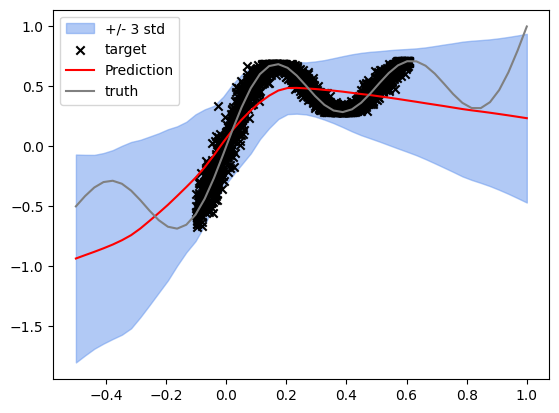

In [138]:
BBB_Regression(x,y,x_test,y_test)

SGD Training Begins!
Epoch:  0 Loss:  0.1760229915380478
Epoch:  10 Loss:  0.09557289630174637
Epoch:  20 Loss:  0.09337599575519562
Epoch:  30 Loss:  0.09063293784856796
Epoch:  40 Loss:  0.08716727048158646
Epoch:  50 Loss:  0.08290514349937439
Epoch:  60 Loss:  0.07799441367387772
Epoch:  70 Loss:  0.07295326143503189
Epoch:  80 Loss:  0.06852709501981735
Epoch:  90 Loss:  0.06513165682554245
Epoch:  100 Loss:  0.06273943930864334
Epoch:  110 Loss:  0.06203436478972435
Epoch:  120 Loss:  0.07119577378034592
Epoch:  130 Loss:  0.06068475916981697
Epoch:  140 Loss:  0.05549641326069832
Epoch:  150 Loss:  0.05276300385594368
Epoch:  160 Loss:  0.059471987187862396
Epoch:  170 Loss:  0.05682314932346344
Epoch:  180 Loss:  0.047181323170661926
Epoch:  190 Loss:  0.046495821326971054
Epoch:  200 Loss:  0.05538465455174446
Epoch:  210 Loss:  0.04987465217709541
Epoch:  220 Loss:  0.046429019421339035
Epoch:  230 Loss:  0.045342929661273956
Epoch:  240 Loss:  0.04369255155324936
Epoch:  250

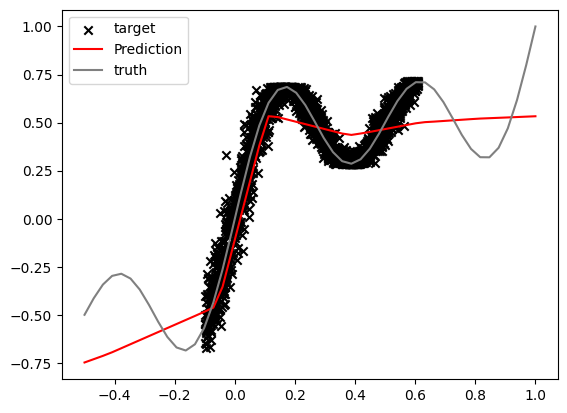

In [142]:
NN_Regression(x,y,x_test,y_test)